In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math


In [17]:
class DiffusionForwardProcess:
    """
    Le forward process
    """
    def __init__(self,
                 num_time_steps = 1000,
                 beta_start = 1e-4,
                 beta_end = 0.02
                ):
        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)

    def add_noise(self, original, noise, t):
        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]

        # Broadcast to multiply with the original image.
        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]

        # Return
        return (sqrt_alpha_bar_t * original) \
                           + \
               (sqrt_one_minus_alpha_bar_t * noise)


class DiffusionReverseProcess:
    """
    Reverse diffusion processs
    """
    def __init__(self,
                 num_time_steps = 1000,
                 beta_start = 1e-4,
                 beta_end = 0.02
                ):

        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.b = torch.linspace(beta_start, beta_end, num_time_steps) # b -> beta
        self.a = 1 - self.b # a -> alpha
        self.a_bar = torch.cumprod(self.a, dim=0) # a_bar = alpha_bar

    def sample_prev_timestep(self, xt, noise_pred, t):
        # Original Image Prediction at timestep t
        x0 = xt - (torch.sqrt(1 - self.a_bar.to(xt.device)[t]) * noise_pred)
        x0 = x0/torch.sqrt(self.a_bar.to(xt.device)[t])
        x0 = torch.clamp(x0, -1., 1.)

        # mean of x_(t-1)
        mean = (xt - ((1 - self.a.to(xt.device)[t]) * noise_pred)/(torch.sqrt(1 - self.a_bar.to(xt.device)[t])))
        mean = mean/(torch.sqrt(self.a.to(xt.device)[t]))

        # only return mean
        if t == 0:
            return mean, x0

        else:
            variance =  (1 - self.a_bar.to(xt.device)[t-1])/(1 - self.a_bar.to(xt.device)[t])
            variance = variance * self.b.to(xt.device)[t]
            sigma = variance**0.5
            z = torch.randn(xt.shape).to(xt.device)

            return mean + sigma * z, x0

In [18]:
def get_time_embedding(
    time_steps: torch.Tensor,
    t_emb_dim: int
) -> torch.Tensor:

    """
    Transform a scalar time-step into a vector representation of size t_emb_dim.
    """
    assert t_emb_dim%2 == 0, "time embedding must be divisible by 2."
    factor = 2 * torch.arange(start = 0,
                              end = t_emb_dim//2,
                              dtype=torch.float32,
                              device=time_steps.device
                             ) / (t_emb_dim)

    factor = 10000**factor
    t_emb = time_steps[:,None] # B -> (B, 1)
    t_emb = t_emb/factor # (B, 1) -> (B, t_emb_dim//2)
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=1) # (B , t_emb_dim)

    return t_emb

In [19]:

class Unet(nn.Module):
    def __init__(self, input_channels, output_channels, int_channels=16, time_dim=16):
        super(Unet, self).__init__()

        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, int_channels),
            nn.ReLU(),
            nn.Linear(int_channels, int_channels)
        )

        self.conv11 = nn.Conv2d(input_channels, int_channels, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv12 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1, dilation=1)

        self.conv21 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=2, dilation=2)
        self.conv22 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=2, dilation=2)

        self.conv31 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=4, dilation=4)
        self.conv32 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=4, dilation=4)
        self.conv33 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=4, dilation=4)

        self.convu21 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)
        self.convu22 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)
        self.convu11 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)
        self.convu12 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)

        self.convout = nn.Conv2d(int_channels, output_channels, kernel_size=1, stride=1)
        torch.nn.init.kaiming_normal_(self.convout.weight, nonlinearity='linear')

    def forward(self, x, t_emb):
        t_emb = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)  # [B, C, 1, 1]
        # First block
        x11 = F.relu(self.conv11(x) + t_emb)
        x12 = self.conv12(x11)
        # Second block with dilation
        x21 = F.relu(self.conv21(x12) + t_emb)
        x22 = self.conv22(x21)
        # Third block with dilation
        x31 = F.relu(self.conv31(x22) + t_emb)
        x32 = F.relu(self.conv32(x31))
        x33 = self.conv33(x32)
        # Upsampling path with explicit size matching
        xu20 = F.interpolate(x33, size=x22.shape[2:], mode='bilinear', align_corners=False)
        xu21 = F.relu((xu20 + x22) / math.sqrt(2))
        xu22 = F.relu(self.convu21(xu21) + t_emb)
        xu23 = self.convu22(xu22)
        xu10 = F.interpolate(xu23, size=x12.shape[2:], mode='bilinear', align_corners=False)
        xu11 = F.relu((xu10 + x12) / math.sqrt(2))
        xu12 = F.relu(self.convu11(xu11) + t_emb)
        xu13 = F.relu(self.convu12(xu12))
        # Final output layer
        out = self.convout(xu13)
        return out



Epoch [1/100], Loss: 0.2402
Epoch [2/100], Loss: 0.0866
Epoch [3/100], Loss: 0.0708
Epoch [4/100], Loss: 0.0634
Epoch [5/100], Loss: 0.0591
Epoch [6/100], Loss: 0.0553
Epoch [7/100], Loss: 0.0523
Epoch [8/100], Loss: 0.0508
Epoch [9/100], Loss: 0.0485
Epoch [10/100], Loss: 0.0479
Epoch [11/100], Loss: 0.0467
Epoch [12/100], Loss: 0.0458
Epoch [13/100], Loss: 0.0453
Epoch [14/100], Loss: 0.0446
Epoch [15/100], Loss: 0.0435
Epoch [16/100], Loss: 0.0428
Epoch [17/100], Loss: 0.0425
Epoch [18/100], Loss: 0.0420
Epoch [19/100], Loss: 0.0418
Epoch [20/100], Loss: 0.0410
Epoch [21/100], Loss: 0.0407
Epoch [22/100], Loss: 0.0404
Epoch [23/100], Loss: 0.0399
Epoch [24/100], Loss: 0.0398
Epoch [25/100], Loss: 0.0394
Epoch [26/100], Loss: 0.0382
Epoch [27/100], Loss: 0.0386
Epoch [28/100], Loss: 0.0380
Epoch [29/100], Loss: 0.0380
Epoch [30/100], Loss: 0.0377
Epoch [31/100], Loss: 0.0375
Epoch [32/100], Loss: 0.0374
Epoch [33/100], Loss: 0.0365
Epoch [34/100], Loss: 0.0365
Epoch [35/100], Loss: 0

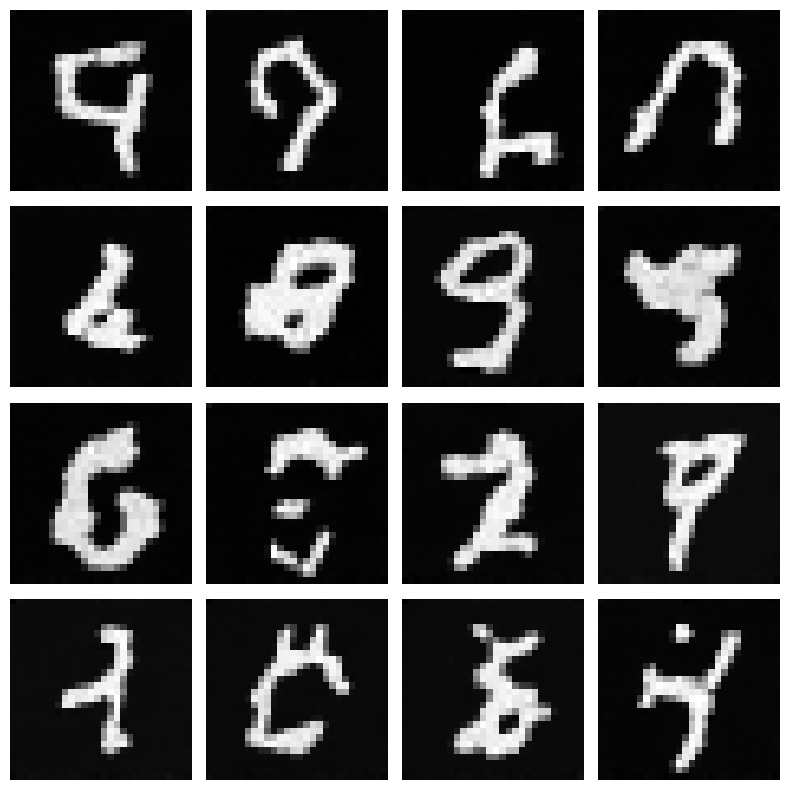

In [20]:


class DDPMTrainer:
    def __init__(self, model, forward_process, reverse_process, device="cuda"):
        self.model = model
        self.forward_process = forward_process
        self.reverse_process = reverse_process
        self.device = device

    def train(self, dataloader, optimizer, epochs):
        self.model.train()
        mse_loss = nn.MSELoss()
        num_time_steps = len(self.forward_process.betas)

        for epoch in range(epochs):
            total_loss = 0
            for images, _ in dataloader:
                images = images.to(self.device)
                batch_size = images.size(0)

                # Randomly sample timesteps
                t = torch.randint(0, num_time_steps, (batch_size,), device=self.device)

                # Sample noise
                noise = torch.randn_like(images)

                # Add noise using the forward process
                noised_images = self.forward_process.add_noise(images, noise, t)

                # Time embedding
                t_emb = get_time_embedding(t, self.model.time_mlp[0].in_features).to(self.device)

                # Predict noise
                predicted_noise = self.model(noised_images, t_emb)

                # Compute loss
                loss = mse_loss(predicted_noise, noise)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

    def sample(self, num_samples, image_size):
        self.model.eval()
        num_time_steps = len(self.reverse_process.b)

        with torch.no_grad():
            # Start from random noise
            x = torch.randn((num_samples, 1, image_size, image_size), device=self.device)

            for t in reversed(range(num_time_steps)):
                t_tensor = torch.full((num_samples,), t, device=self.device, dtype=torch.long)

                # Time embedding
                t_emb = get_time_embedding(t_tensor, self.model.time_mlp[0].in_features).to(self.device)

                # Predict noise
                predicted_noise = self.model(x, t_emb)

                # Reverse process
                x, _ = self.reverse_process.sample_prev_timestep(x, predicted_noise, t)

        return x

# Define the MNIST dataset
def get_mnist_dataloader(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)
    return dataloader

# Define beta schedule
num_time_steps = 1000
beta_start = 1e-4
beta_end = 0.02
beta_schedule = torch.linspace(beta_start, beta_end, num_time_steps)

# Instantiate classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Forward and reverse processes
forward_process = DiffusionForwardProcess(
    num_time_steps=num_time_steps, beta_start=beta_start, beta_end=beta_end
)
reverse_process = DiffusionReverseProcess(
    num_time_steps=num_time_steps, beta_start=beta_start, beta_end=beta_end
)

# UNet model
unet = Unet(input_channels=1, output_channels=1, time_dim=num_time_steps).to(device)

# Trainer
trainer = DDPMTrainer(unet, forward_process, reverse_process, device)

# Optimizer and data
optimizer = optim.Adam(unet.parameters(), lr=1e-4)
dataloader = get_mnist_dataloader(batch_size=64)

# Train the model
trainer.train(dataloader, optimizer, epochs=100)

# Generate samples
samples = trainer.sample(num_samples=16, image_size=28)

# Visualize generated samples
samples = samples.cpu().numpy()
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i, 0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()